In [1]:
### Benjamin Tollison Hw3 ###
import sympy as sp
from IPython.display import display, Math, Latex
from sympy.solvers.solveset import linsolve
from sympy import  lambdify, Matrix, sinh, cosh, exp, pi, symbols
import numpy as np
import matplotlib.pyplot as plt
def displayEquations(LHS,RHS):
    left = sp.latex(LHS)
    right = sp.latex(RHS)
    display(Math(left + '=' + right))

In [2]:
#### Analytical solution ####
# Governing equation
A,B,C,D,alpha_1,alpha_2,x,h,L = symbols('A B C D alpha_1 alpha_2 x h L')
u_1 = A*sinh(alpha_1*x) + B*cosh(alpha_1*x)
u_2 = C*sinh(alpha_2*x) + D*cosh(alpha_2*x)
P = 2*pi*x
bc1 = u_1.subs(x,0) - 100
bc2 = u_1.subs(x,1/2) - u_2.subs(x,0)
bc3 = u_2.diff(x).subs(x,1/2) - h*P*u_2.subs({x:1/2})
bc4 = u_1.diff(x).subs(x,1/2)  - h*P*(u_1.subs({x:1/2})-u_2.subs({x:0}))
dof = sp.nonlinsolve([bc1,bc2,bc3,bc4],[A,B,C,D])
(a_sol,b_sol,c_sol,d_sol) = next(iter(dof))
u_1 = u_1.subs({A:a_sol,B:b_sol})
u_2 = u_2.subs({C:c_sol,D:d_sol})
displayEquations('u_1',u_1)
displayEquations('u_2',u_2)
displayEquations('A',a_sol)
displayEquations('B',b_sol)
displayEquations('C',c_sol.subs({P:2*pi*x}))
displayEquations('D',d_sol.subs({P:2*pi*x}))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [3]:
print(u_2)

-(100*alpha_2*sinh(0.5*alpha_2) - 200*pi*h*x*cosh(0.5*alpha_2))*sinh(alpha_2*x)/((alpha_2*cosh(0.5*alpha_2) - 2*pi*h*x*sinh(0.5*alpha_2))*cosh(0.5*alpha_1)) + 100*cosh(alpha_2*x)/cosh(0.5*alpha_1)


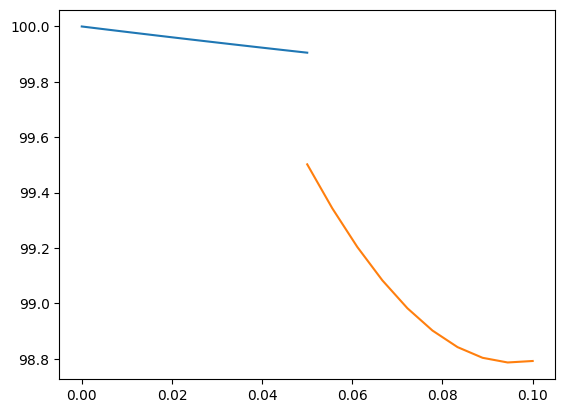

In [4]:
# Lets set alpha_1 = .2 and alpha_2 = .8, h = .5
from numpy import cosh,sinh,pi,exp
r = .1
u_1_graph = lambdify((x,alpha_1),u_1)
u_2_graph = lambdify((x, alpha_1, alpha_2, h), u_2)
x1_test_np_values = np.linspace(0,.5*r,10)
x2_test_np_values = np.linspace(.5*r,r,10)
plt.plot(x1_test_np_values,u_1_graph(x1_test_np_values,.2))
plt.plot(x2_test_np_values,u_2_graph(x1_test_np_values,.2,.8,.5))
plt.show()

In [24]:
#### FEM ####
phi_1,phi_2,phi_3,phi_4 = symbols('phi_1,phi_2,phi_3,phi_4')
#### Linear Interpolation Equation ####
G = Matrix([1,x]).T
#displayEquations('G',G)
H = Matrix([[G.subs({x:0})],[G.subs({x:L})]])
#displayEquations('H',H)
q = G @ H.inv()
displayEquations(phi_1,q.T)
#### Cubic Interpolation Equation ####
G = Matrix([1,x,x**2,x**3]).T
H = Matrix([[G.subs({x:0})],[G.diff(x).subs({x:0})],[G.subs({x:L})],[G.diff(x).subs({x:L})]])
#displayEquations('G',G)
#displayEquations('H',H)
q = G @ H.inv()
displayEquations(phi_2,q.T)
N = q # sp.integrate(q.diff(x,x)*q.diff(x,x).T,(x,0,L))
N = Matrix([[1 - 3*x**2/L**2 + 2*x**3/L**3],[x - 2*x**2/L + x**3/L**2],[3*x**2/L**2 - 2*x**3/L**3],[-x**2/L + x**3/L**2]])
K = sp.integrate(N.diff(x,x)*N.diff(x,x).T,(x,0,L)).subs({L:h})
print(K)
#### P = 3 ####
G = Matrix([1,x,x**2,x**3,x**4,x**5]).T
H = Matrix([[G.subs({x:0})],[G.diff(x).subs({x:0})],[G.diff(x,x).subs({x:0})],[G.subs({x:L})],[G.diff(x).subs({x:L})],[G.diff(x,x).subs({x:L})]])
q = G @ H.inv()
displayEquations(phi_3,q.T)
#### P = 4 ####
G = Matrix([1,x,x**2,x**3,x**4,x**5,x**6,x**7]).T
H = Matrix([[G.subs({x:0})],[G.diff(x).subs({x:0})],[G.diff(x,x).subs({x:0})],[G.diff(x,x,x).subs({x:0})],[G.subs({x:L})],[G.diff(x).subs({x:L})],[G.diff(x,x).subs({x:L})],[G.diff(x,x,x).subs({x:L})]])
q = G @ H.inv()
displayEquations(phi_4,q.T)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Matrix([[12/h**3, 6/h**2, -12/h**3, 6/h**2], [6/h**2, 4/h, -6/h**2, 2/h], [-12/h**3, -6/h**2, 12/h**3, -6/h**2], [6/h**2, 2/h, -6/h**2, 4/h]])


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
#### Local fdm function #### 
def P(x):
    return 2*np.pi*x
def Local_Coeff_matrix(number_of_nodes,alpha):
    i = number_of_nodes
    delta_x = 1 / (i+1)
    kap = 2 + alpha**2 * delta_x**2
    kapppa_prime = 1 + h*P(x)*(2*delta_x + 1/3 * alpha**2 * delta_x**3)\
        + alpha**2 * delta_x**2
    Coefficient_Matrix = np.zeros((i,i))
    Coefficient_Matrix[i-1][i-2:i] = [kapppa_prime,-1]
    Coefficient_Matrix[0][0:2] = [kap, -1]
    for j in range(1,i-1):
        Coefficient_Matrix[j][j-1:j+2] = [-1, kap, -1]
    return Coefficient_Matrix